In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize parameters and Laplace kernel

#### Sparse modeling

This notebook uses principles of sparse modeling to reconstruct a spectral function $\rho(\omega)$ from finite Green's function data $G(\tau)$. $G$ is constructed from the spectral function by a Laplace transform,
$$
    G(\tau) = \int_\mathbb{R} d\omega\, e^{-\omega\tau}\rho(\omega).
$$
This method will discretize the Laplace transform to write it as a matrix equation. The Green's function $G(\tau)$ is evaluated at discrete $\{\tau_i\}$ of size $N_\tau$, and the spectral function is evaluated at discrete $\{\omega_j\}$ of size $N_\omega$, and the discretized vectors are $\mathbf G_i = G(\tau_i)$ and $\mathbf \rho_j = \rho(\omega_j)$. In this form, the previous equation becomes a matrix equation,
$$
    \mathbf{G}_i = K_{ij} \mathbf{\rho}_j,
$$
where $K_{ij} = e^{-\tau_i \omega_j}$ is the discretized Laplace kernel, a matrix of size $N_\tau\times N_\omega$. 

The approach we will take to solving this problem is to exploit the sparsity of $\rho(\omega)$ in a so-called "Intermediate Representation (IR)". An IR is defined by performing a singular value decomposition of $K_{ij}$:
$$
    K = U S V^\dagger,
$$
where $U, V$ are respectively unitary $N_\tau\times N_\tau$ and $N_\omega\times N_\omega$ matrices, and S is the diagonal matrix of singular values. The IR specific to $K$ (as we will have different representations depending on the dimension of $U$ and $V$) is defined as a rotation of $\mathbf G$ and $\mathbf \rho$ by the corresponding unitary matrices $U$ and $V^\dagger$:
\begin{align}
    \mathbf G' = U^\dagger \mathbf G && \mathbf \rho' = V^\dagger \mathbf \rho.
\end{align}
In this representation the components of $\mathbf G'$ and $\mathbf \rho'$ are related by multiplication with a singular value $s_\ell\equiv S_{\ell\ell}$ (note here there is no sum on $\ell$):
$$
    \mathbf G'_\ell = s_\ell \mathbf \rho'_\ell.
$$

In this representation, the spectral function is \textbf{sparse}, meaning that it has a large number of components which are zero or very close to 0. We can exploit the sparsity to solve the Least Absolute Shrinkage and Selection Operator (LASSO) problem, which is the optimization problem which corresponds to the minimization of the following function,
$$
    F_{LASSO}(\mathbf x) = \frac{1}{2} ||\mathbf G - K \mathbf x||_2^2 + \lambda ||\mathbf x||_1,
$$
where $||\cdot||_p$ is the $L^p$ norm and $\lambda$ is a \textbf{hyperparameter}, meaning that it is chosen and tweaked by the user to find the best solution to the inverse problem. The $L_1$ norm term is interpreted as a penalty; the optimization searches through the space of $\mathbf x$ and tries to minimize the objective function $|| \mathbf G - K\mathbf x||_2^2$, subject to also trying to minimize $||\mathbf x||_1$. If $\lambda$ is small, minimization of the objective function is most important; however if $\lambda$ is large, minimization of the $L_1$ norm is more important, and so the choise of $\lambda$ is a choice between getting the closest solution to the input data and having a solution which is sparse. 

Note that in our problem, we want to perform the minimization subject to the sparsity of $\mathbf{\rho}'$, the components of $\mathbf \rho$ in an IR. That is, we solve for $\mathbf{\rho}'$ in the following optimization problem:
$$
    \mathbf{\rho'} = \arg\min_\mathbf{\rho'} \left[\frac{1}{2}|| \mathbf{G}' - S \mathbf{\rho}' ||_2^2 + \lambda ||\mathbf{\rho}'||_1\right]
$$
and then rotate back to $\mathbf{\rho} = V \mathbf{\rho}'$ afterward.

In [2]:
# Use a Gaussian spectral function centered at omega0 with width delOmega
# T = 32
# omega0 = 0.8
# delOmega = 0.2
# rho = lambda omega : 10 * np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)

T = 8
omega_supp = [0.8, 1.1]
rho = lambda omega : 1 / (omega_supp[1] - omega_supp[0]) if omega > omega_supp[0] and omega < omega_supp[1] else 0

# omega_line = np.linspace(-5, 5, 1000)
omega_line = np.linspace(0, 2, 100)
def signal(tau):
    integrand = lambda omega : np.exp(-omega * tau) * rho(omega)
    return quad(integrand, 0, np.inf)[0]
rho_dat = np.array([rho(a) for a in omega_line])

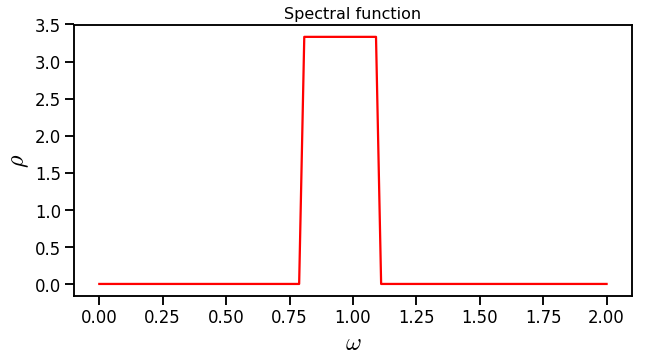

In [3]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rho_dat, colors = 'r', title = 'Spectral function', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)

In [4]:
# omega_bounds = [0, 2]
# domega = 0.01
# omegas = np.arange(omega_bounds[0], omega_bounds[1], domega)
omegas = omega_line
np.random.seed(10)
# taus = np.arange(1, T - 1)
taus = np.arange(T)
G = np.array([signal(t) for t in taus])
print('Evaluating Greens function at tau = it = ' + str(taus))

Evaluating Greens function at tau = it = [0 1 2 3 4 5 6 7]


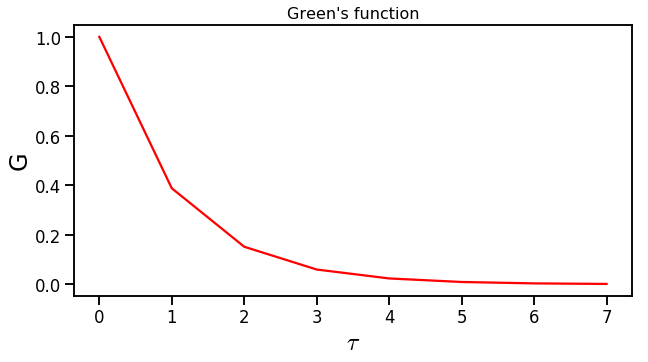

In [5]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, G, colors = 'r', title = 'Green\'s function', ax_label = ['$\\tau$', 'G'], \
                     legend = False)

In [6]:
kernel = laplace_kernel(taus, omegas)
U, svals, Vdag = np.linalg.svd(kernel)
S = np.pad(np.diag(svals), [(0, 0), (0, len(omegas) - len(taus))])

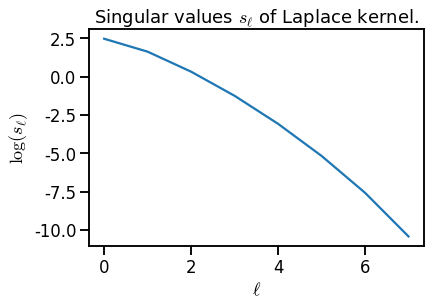

In [7]:
# The area where the singular values asymptote is likely machine precision. 
with sns.plotting_context('talk'):
    plt.figure()
    plt.plot(np.log(svals))
    plt.xlabel('$\ell$')
    plt.ylabel('$\log(s_\ell)$')
    plt.title('Singular values $s_\ell$ of Laplace kernel.')
    plt.show()

## Solve inverse problem with ADMM

#### ADMM

The Alternating Direction Method of Multipliers (ADMM) is an algorithm which solves the LASSO problem. 

In [8]:
lam = 0.2          # hyperparameter
fid = lpnorm(2)    # later generalize this to covariance matrix
reg = lpnorm(1)    # regulator
objective = lin_combo([1., fid], [lam, reg])

In [9]:
Vdag.conj().T

array([[-0.1834591 , -0.34503267,  0.34158856, ..., -0.0230314 ,
        -0.01272945, -0.00150118],
       [-0.17671393, -0.31019523,  0.26236654, ...,  0.10930996,
         0.10472793,  0.0997489 ],
       [-0.17052028, -0.27863213,  0.1939931 , ..., -0.1684599 ,
        -0.1805986 , -0.19328865],
       ...,
       [-0.07457735,  0.09171051,  0.1159741 , ...,  0.85989574,
        -0.15576872, -0.17217497],
       [-0.0744601 ,  0.0918939 ,  0.11742376, ..., -0.15675121,
         0.82441615, -0.19535596],
       [-0.07434567,  0.09207191,  0.11884047, ..., -0.1742424 ,
        -0.19644251,  0.78020575]])